# Environment Config

## Imports

In [1]:
import os
from collections import Cou   nter
import splitfolders
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## GPU using

In [2]:
print("You using Tensorflow version in: ", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Using GPU.")
    
    !nvidia-smi
else:
    print("Not using GPU.")

You using Tensorflow version in:  2.10.0
Using GPU.
Sun Jun  2 00:53:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8               5W /  90W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------

# Datasets Upload 

## Define Dirs

In [3]:
input_dir = os.path.join(os.path.dirname(os.getcwd()),
                         "assets", "images", "dataset", "drowsiness_database")
output_dir = os.path.join(os.path.dirname(
    os.getcwd()), "assets", "images", "splitted_dataset", "drowsiness_database")

train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
val_dir = os.path.join(output_dir, "val")

## Split Data

In [4]:
def is_dir_empty(dir_path):
    return not any(os.scandir(dir_path))

In [5]:
if not (os.path.exists(train_dir) and os.path.exists(test_dir) and os.path.exists(val_dir) and
        not (is_dir_empty(train_dir) or is_dir_empty(test_dir) or is_dir_empty(val_dir))):

    splitfolders.ratio(input_dir, output=output_dir,
                       seed=842, ratio=(.8, 0.15, 0.05))
    print("Dataset splitting complete!")
else:
    print("Dataset split already exists and appears to contain data. Skipping splitting.")

Dataset split already exists and appears to contain data. Skipping splitting.


# Reading Data


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.


In [8]:
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 2091 images belonging to 2 classes.


In [9]:
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 6268 images belonging to 2 classes.


# Preprocessing

In [10]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'drowsy': 0, 'non_drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class Names for test:
 {'drowsy': 0, 'non_drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class Names for validation :
 {'drowsy': 0, 'non_drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})


Pixels of the first image after Normalization: 

[[[0.5058824  0.45098042 0.31764707]
  [0.5058824  0.45098042 0.31764707]
  [0.5058824  0.45098042 0.31764707]
  ...
  [1.         0.9960785  0.9215687 ]
  [1.         1.         0.9686275 ]
  [1.         1.         0.9960785 ]]

 [[0.5019608  0.44705886 0.31764707]
  [0.5019608  0.44705886 0.31764707]
  [0.5058824  0.45098042 0.32156864]
  ...
  [1.         0.9960785  0.9333334 ]
  [1.         1.         0.96470594]
  [1.         1.         0.9803922 ]]

 [[0.49803925 0.4431373  0.3137255 ]
  [0.5019608  0.44705886 0.31764707]
  [0.5058824  0.45098042 0.3254902 ]
  ...
  [1.         1.         0.9568628 ]
  [1.         1.         0.9568628 ]
  [1.         1.         0.9607844 ]]

 ...

 [[0.43921572 0.3921569  0.31764707]
  [0.4431373  0.3921569  0.31764707]
  [0.45098042 0.40000004 0.3254902 ]
  ...
  [0.10196079 0.01568628 0.        ]
  [0.13333334 0.04313726 0.01960784]
  [0.14901961 0.05882353 0.03137255]]

 [[0.43921572 0.3921569  

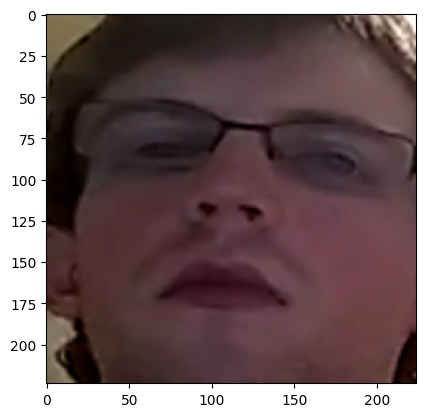

In [11]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}")
plt.imshow(images[0])
plt.show()

In [12]:
print(f"there are {images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


## Showing some images to training

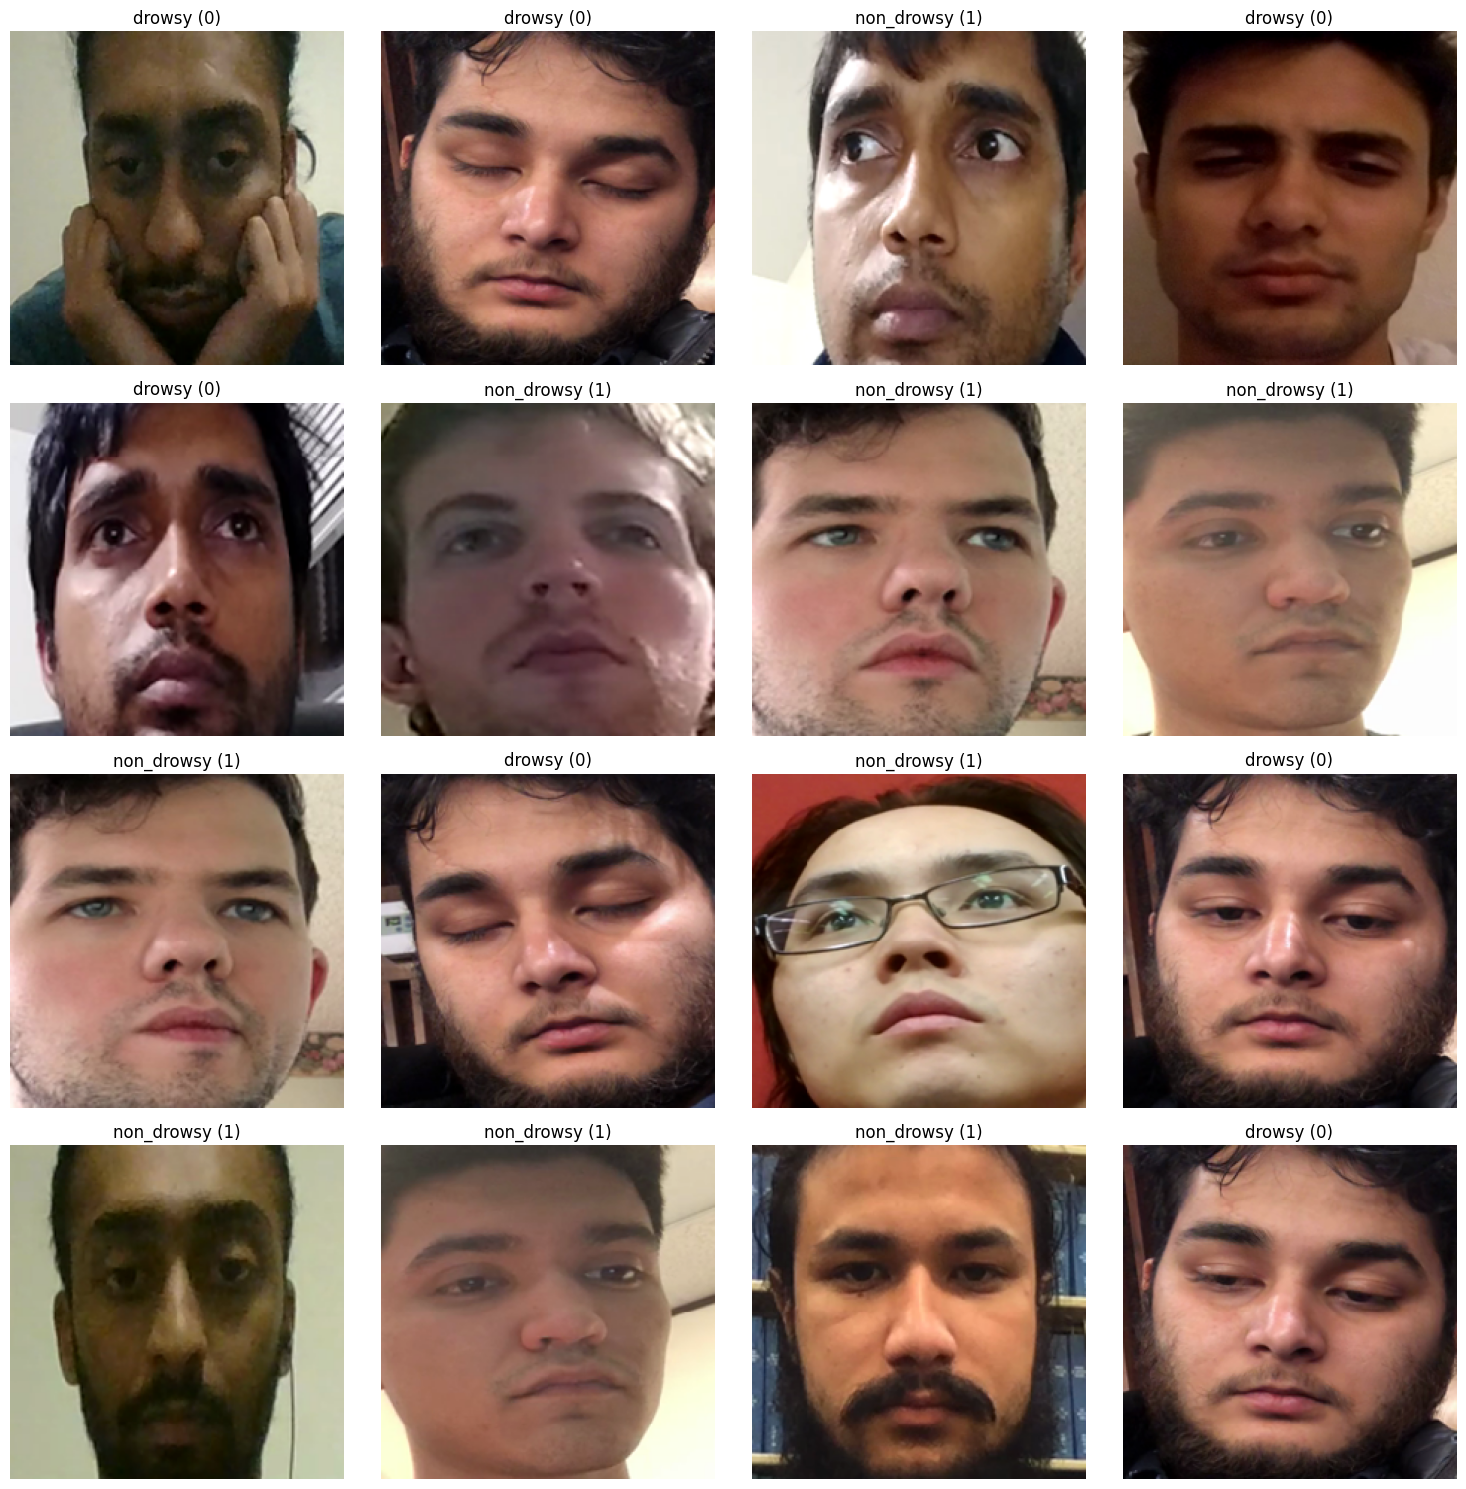

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
class_indices = train_batches.class_indices

for i in range(4):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[
            list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

# Modeling

## Create Model

In [14]:
base_model = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
)

## Architecture of Base Model

In [15]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

## Creating Sequential Model

In [16]:
model = keras.Sequential()

In [17]:
for layer in base_model.layers[:-25]:
    layer.trainable = False

In [18]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

## Architecture of Sequencial Model

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

## Compiling

In [21]:
model.compile(optimizer=SGD(0.00008),
              loss=binary_crossentropy, metrics=['accuracy'])

## Training

In [22]:
callback = ModelCheckpoint(
    filepath='models/checkpoints/drowsiness_model.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

In [23]:
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches,
    batch_size=32,
    callbacks=callback
)

Epoch 1/10
2090/2090 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.8980
Epoch 1: val_loss improved from inf to 0.66635, saving model to models/checkpoints\drowsiness_model.keras
2090/2090 [==============================] - 309s 143ms/step - loss: 0.3327 - accuracy: 0.8980 - val_loss: 0.6663 - val_accuracy: 0.5866
Epoch 2/10
2090/2090 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9757
Epoch 2: val_loss improved from 0.66635 to 0.30031, saving model to models/checkpoints\drowsiness_model.keras
2090/2090 [==============================] - 302s 144ms/step - loss: 0.1670 - accuracy: 0.9757 - val_loss: 0.3003 - val_accuracy: 0.9004
Epoch 3/10
2090/2090 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9859
Epoch 3: val_loss improved from 0.30031 to 0.10045, saving model to models/checkpoints\drowsiness_model.keras
2090/2090 [==============================] - 294s 140ms/step - loss: 0.1094 - accuracy: 0.9859 - val_loss:

## Show Diagram of Architecture

In [24]:
# tf.keras.utils.plot_model(model, show_shapes=True)

# Evaluating

## Basic Evaluating

In [25]:
loss, accuracy = model.evaluate(train_batches)

print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy*100:.2f}%")

2090/2090 [==============================] - 20190s 10s/step - loss: 0.0222 - accuracy: 0.9973
Training Loss: 0.0222
Training Accuracy: 99.73%


In [26]:
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

131/131 [==============================] - 18s 135ms/step - loss: 0.0241 - accuracy: 0.9962
Test Loss: 0.0241
Test Accuracy: 99.62%


In [27]:
keras_model = load_model('models/checkpoints/drowsiness_model.keras')
score = keras_model.evaluate(test_batches)

131/131 [==============================] - 6s 41ms/step - loss: 0.0241 - accuracy: 0.9962


## Learning Curve

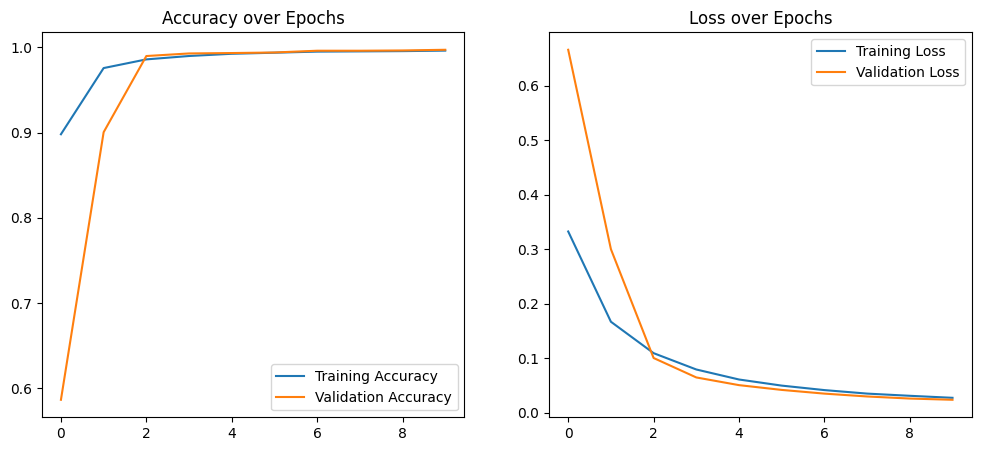

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Prediction

In [29]:
y_pred = model.predict(test_batches)

y_pred_labels = np.argmax(y_pred, axis=1)

131/131 [==============================] - 6s 41ms/step


In [30]:
def predict_drowsiness(image_path):
  img = image.load_img(image_path, target_size=(224, 224))
  x = image.img_to_array(img)

  x /= 255.
  x = np.expand_dims(x, axis=0)

  predictions = keras_model.predict(x)
  predicted_proba = predictions[0][0]
  predicted_label = "Drowsy" if predicted_proba > 0.5 else "Not Drowsy"

  return predicted_proba, predicted_label, img

1/1 [==============================] - 1s 642ms/step
Predicted Probability of Drowsiness: 0.67
Predicted Label: Drowsy


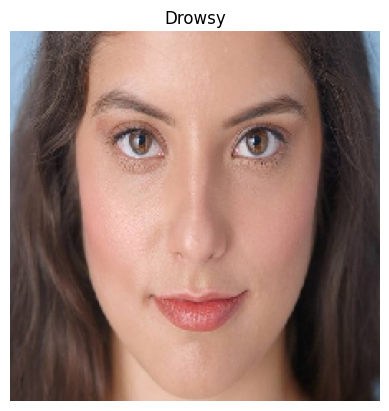

In [31]:
image_path = os.path.join(os.path.dirname(os.getcwd()), "assets", "images", "test", "teste.png")
predicted_proba, predicted_label, img = predict_drowsiness(image_path)

print(f"Predicted Probability of Drowsiness: {predicted_proba:.2f}")
print(f"Predicted Label: {predicted_label}")

plt.imshow(img)
plt.title(predicted_label)
plt.axis('off')
plt.show()

# Confusion Matrix

In [32]:
y_actual = test_batches.labels

In [33]:
conf_matrix = confusion_matrix(y_actual, y_pred_labels)

print(conf_matrix)

[[1118    0]
 [ 973    0]]


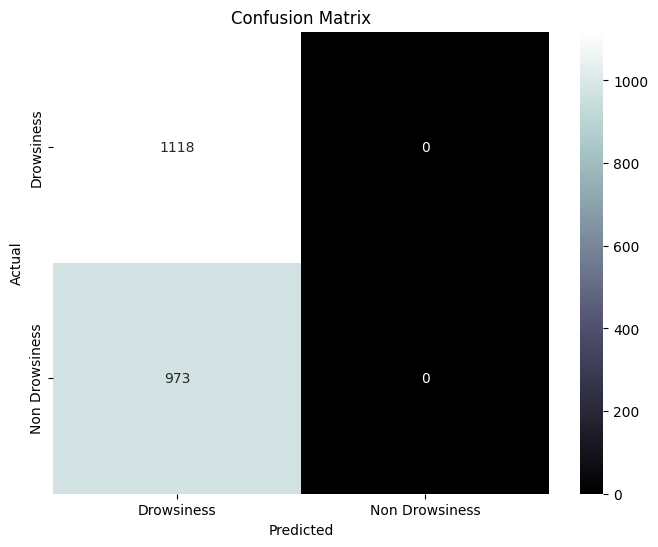

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone',
            xticklabels=['Drowsiness', 'Non Drowsiness'],
            yticklabels=['Drowsiness', 'Non Drowsiness'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
report = classification_report(y_actual, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.53      1.00      0.70      1118
           1       0.00      0.00      0.00       973

    accuracy                           0.53      2091
   macro avg       0.27      0.50      0.35      2091
weighted avg       0.29      0.53      0.37      2091



c:\Users\rhogg\miniconda3\envs\sleep\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rhogg\miniconda3\envs\sleep\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rhogg\miniconda3\envs\sleep\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Generate Model to Deploy

In [36]:
model.save_weights(f"models/drowsy/drowsiness_model_acc_{round(accuracy*100, 2)}.weights.h5")

In [37]:
model_json = model.to_json()
with open(f"models/drowsy/drowsiness_model_acc_{round(accuracy*100, 2)}.json", "w") as json_file:
    json_file.write(model_json)

# Convert model to TFLite

In [38]:
model = load_model('models/checkpoints/drowsiness_model.keras')

In [39]:
model.save(f"models/drowsy/drowsiness_model.h5")
model.save(f"models/drowsy/drowsiness_model.keras")

In [40]:
saved_model_dir = 'models/drowsy/saved_model'
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: models/drowsy/saved_model\assets


INFO:tensorflow:Assets written to: models/drowsy/saved_model\assets


In [41]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

In [42]:
with open('models/drowsy/drowsiness_model.tflite', 'wb') as f:
    f.write(tflite_model)